# This notebook delineates the watershed for all culverts
##### Author: Omid Emamjomehzadeh (https://www.omidemam.com/)
##### Supervisor: Dr. Omar Wani (https://engineering.nyu.edu/faculty/omar-wani)
##### Hydrologic Systems Group @NYU (https://www.omarwani.com/)

In [6]:
#import libraries
import whitebox 
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import colormaps
from matplotlib_scalebar.scalebar import ScaleBar
from contextlib import contextmanager
from shapely.ops import split
from shapely.geometry import LineString, Polygon
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from watermark import watermark
import random
import pyproj
from pyproj import CRS
from datetime import datetime
import requests
import os
import shutil
import sys
import subprocess
import datetime

WhiteboxTools hydrological analyses is used to perform watershed delineation :https://www.whiteboxgeo.com/manual/wbt_book/available_tools/hydrological_analysis.html

In [7]:
# Define watershed delineation tool
wbt = whitebox.WhiteboxTools()

In [8]:
# This function stops the White box tool from outputting text in the notebook
@contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

In [4]:
#Define layers directories
output_huc12_dir = r'D:\culvert repo\Results\Clipped_layers\clipped_huc12'
output_stream_dir = r'D:\culvert repo\Results\Clipped_layers\clipped_streams'
output_road_dir = r'D:\culvert repo\Results\Clipped_layers\clipped_street'
output_railroad_dir = r'D:\culvert repo\Results\Clipped_layers\clipped_railroad'
output_culvert_dir = r'D:\culvert repo\Results\Clipped_layers\clipped_culverts'
output_DEM_dir=r'D:\culvert repo\Results\Clipped_layers\HUC12_one meter_DEM'

In [5]:
# Read HUC12 list
file_path = r"D:\culvert repo\Results\Lists\huc12_with_all_layers.txt"
with open(file_path, 'r') as file:
    huc12_with_all_layers = [line.strip() for line in file]
total_hucs=len(huc12_with_all_layers)    

In [46]:
%%time
results = []
huc_analysed_correc=[]
for i, huc in enumerate(huc12_with_all_layers):

    # Check if the file exists; if so, skip to the next iteration
    finalfile=fr'D:\culvert repo\Results\waterhsed_delineation_dir\{huc}\{huc}_watersheds_info.shp'
    if os.path.exists(finalfile):
        print(f"File {finalfile} already exists. Skipping...")
        continue
    # Check if the file exists; if so, skip to the next iteration
    finalfile=fr'C:\hydrological analysis\data\waterhsed_delineation_dir\{huc}\{huc}_watersheds_info.shp'
    if os.path.exists(finalfile):
        print(f"File {finalfile} already exists. Skipping...")
        continue
    # Check if the DEM file exists; if not, skip to the next iteration
    clipped_tiff = os.path.join(rf'D:\culvert repo\Results\Clipped_layers\HUC12_one meter_DEM\{huc}', f'{huc}_DEM.tiff')
    if not  os.path.exists(clipped_tiff):
        print(f"DEM File {clipped_tiff} doenst exist. Skipping...")
        continue
    try:
        print(huc)
        # Print the HUC number and the percent of remaining HUCs in this chunk
        remaining_files = total_hucs - (i + 1)
        percent_remaining = (remaining_files / total_hucs) * 100
        print(f"HUC number: {huc}, Percent of remaining files: {percent_remaining:.2f}%")
        # path to the specific HUC layer
        output_huc12_path = os.path.join(output_huc12_dir, f'{huc}_huc12.shp')
        output_stream_path = os.path.join(output_stream_dir, f'{huc}_streams.shp')
        output_culvert_path = os.path.join(output_culvert_dir, f'{huc}_culverts.shp')
        output_road_path = os.path.join(output_road_dir, f'{huc}_streets.shp')
        output_railroad_path=os.path.join(output_road_dir, f'{huc}_railroads.shp')
        clipped_tiff = os.path.join(rf'D:\culvert repo\Results\Clipped_layers\HUC12_one meter_DEM\{huc}', f'{huc}_DEM.tiff')
        # Load data using Geopandas
        huc12 = gpd.read_file(output_huc12_path)
        streams = gpd.read_file(output_stream_path)
        culverts = gpd.read_file(output_culvert_path)
        roads = gpd.read_file(output_road_path)
        if os.path.exists(output_railroad_path):
            railroads=gpd.read_file(output_road_path)
        ################################################################################################################################################ 
        # make a directory for watershed delineation analysis
        # Define and create the directory
        water_deal_dir_path= fr'C:\hydrological analysis\data\waterhsed_delineation_dir\{huc}'
        # Create the directory if it doesn't exist
        if not os.path.exists(water_deal_dir_path):
            os.makedirs(water_deal_dir_path)
        # Set the working directory
        wbt.set_working_dir(water_deal_dir_path)
        ################################################################################################################################################
        # Lowers the elevation of roads to ground elevation when there is an intersection of stream and roads or railroads
        #(this helps to generate realistic stream flow that accounts for the existence of culverts)
        # fill DEM for slope calculation
        # Generat a Dem file for this calcualtion which is filled but is not burned
        mo_dem_5 = fr'C:\hydrological analysis\data\waterhsed_delineation_dir\{huc}\{huc}_DEM_mo_5.tif'
        with suppress_stdout():
            wbt.fill_depressions(
                clipped_tiff, 
                mo_dem_5, 
                fix_flats=True, 
                flat_increment=None, 
                max_depth=None, 
            )
        ################################################################################################################################################
        roadsburned_dem = fr'C:\hydrological analysis\data\waterhsed_delineation_dir\{huc}\{huc}_DEM_roadsburned.tif'
        with suppress_stdout():
            wbt.burn_streams_at_roads(
                clipped_tiff, 
                output_stream_path, 
                output_road_path, 
                roadsburned_dem, 
                width=60, 
            )
        if os.path.exists(output_railroad_path):
            with suppress_stdout():
                wbt.burn_streams_at_roads(
                    roadsburned_dem, 
                    output_stream_path, 
                    output_road_path, 
                    roadsburned_dem, 
                    width=60, 
                )
        ################################################################################################################################################
        mo_dem_4 = fr'C:\hydrological analysis\data\waterhsed_delineation_dir\{huc}\{huc}_DEM_mo_4.tif'
        with suppress_stdout():
            wbt.fill_depressions(
                roadsburned_dem, 
                mo_dem_4, 
                fix_flats=True, 
                flat_increment=None, 
                max_depth=None, 
            )
        ################################################################################################################################################
        # Generate Flow direction raster file
        flowdirection=  fr'C:\hydrological analysis\data\waterhsed_delineation_dir\{huc}\{huc}_flowdir.tif'
        with suppress_stdout():
            wbt.d8_pointer(
                mo_dem_4, 
                flowdirection, 
                esri_pntr=False, 
            )
        ################################################################################################################################################
        # Generate Flow accumulation raster file
        flowacc=  fr'C:\hydrological analysis\data\waterhsed_delineation_dir\{huc}\{huc}flowacc.tif'
        with suppress_stdout():
            wbt.d8_flow_accumulation(
                mo_dem_4, 
                flowacc, 
                out_type="cells", 
                log=False, 
                clip=False, 
                pntr=False, 
                esri_pntr=False, 
            )
        ################################################################################################################################################
        # Define the culvert_data, which will contain all information from this analysis
        culvert_data = []
        # Define distances
        distances = [ 10, 20, 40, 80]
        for index, row in culverts.iterrows():
            # Construct the filename for each row
            filename = f"{row['BIN']}.shp"
            # Save each row as a shapefile in the output directory
            culvert_output_path = os.path.join(water_deal_dir_path, filename)
            culvert = gpd.GeoDataFrame([row], geometry='geometry',crs=culverts.crs)
            culvert.to_file(culvert_output_path)
            for distance in distances:
                sanppoints_path = fr'C:\hydrological analysis\data\waterhsed_delineation_dir\{huc}\{row["BIN"]}snap_pour_point_{distance}m.shp'
                with suppress_stdout():
                    wbt.snap_pour_points(
                        culvert_output_path, 
                        flowacc, 
                        sanppoints_path, 
                        snap_dist=distance, 
                    )
                sanpped_points=gpd.read_file(sanppoints_path)
                sanpped_points = sanpped_points.set_crs(culverts.crs, allow_override=True)
                ########################################################################################################################################
                # Watershed delineation based on snapped culvert points
                watershed=fr'C:\hydrological analysis\data\waterhsed_delineation_dir\{huc}\{culvert["BIN"].iloc[0]}watershed_{distance}m.tif'
                with suppress_stdout():
                    wbt.watershed(
                        flowdirection, 
                        sanppoints_path, 
                        watershed, 
                        esri_pntr=False, 
                    )
                # Path to the output vector file
                watershed_polygone = fr'C:\hydrological analysis\data\waterhsed_delineation_dir\{huc}\{culvert["BIN"].iloc[0]}watershed_poly_{distance}m.shp'
                with suppress_stdout():
                    # Run the RasterToVectorPolygons tool
                    wbt.raster_to_vector_polygons(watershed, watershed_polygone)
                ########################################################################################################################################
                # longest flow path calculation
                lfp=fr'C:\hydrological analysis\data\waterhsed_delineation_dir\{huc}\{culvert["BIN"].iloc[0]}_lfp_{distance}m.shp'
                with suppress_stdout():
                    wbt.longest_flowpath(
                        mo_dem_4, 
                        watershed, 
                        lfp, 
                    )
                ########################################################################################################################################
                #load the watershed and longest flow path data frames
                watershed_gdf=gpd.read_file(watershed_polygone)
                lfp_gdf=gpd.read_file(lfp)
                # Find the maximum flow path length and average slope
                max_length_rows = lfp_gdf.loc[lfp_gdf.groupby('BASIN')['LENGTH'].idxmax()]
                ########################################################################################################################################
                # calculate the average slope of each basin
                # Clip and save the reprojected DEM
                clipped_tiff_watershed = os.path.join(rf'C:\hydrological analysis\data\waterhsed_delineation_dir\{huc}',
                                                      f'{culvert["BIN"].iloc[0]}_DEM_watershed_.tiff')
                # load watershed polygon
                watershed_pol=gpd.read_file(watershed_polygone)
                # Convert the HUC12 boundary to GeoJSON-like format
                watershed_pol_geom = [feature["geometry"] for feature in watershed_pol.__geo_interface__["features"]]
                # Open the reprojected TIFF file and clip it using the HUC12 boundary
                with rasterio.open(clipped_tiff) as src:
                    out_image, out_transform = mask(src, watershed_pol_geom, crop=True)
                    # Set NoData value
                    out_image[out_image == src.nodata] = -99999
                    out_meta = src.meta.copy()
                    out_meta.update({
                        "driver": "GTiff",
                        "height": out_image.shape[1],
                        "width": out_image.shape[2],
                        "transform": out_transform,
                        "crs": src.crs,
                        "nodata": -99999
                    })
                    # Save the clipped DEM to a new file
                    with rasterio.open(clipped_tiff_watershed, 'w', **out_meta) as dst:
                        dst.write(out_image)
                # calculate the average slope
                # Define input and output file paths
                output_slope = fr'C:\hydrological analysis\data\waterhsed_delineation_dir\{huc}\{culvert["BIN"].iloc[0]}_slope.tif'
                # Run the Slope tool with units in percent
                with suppress_stdout():
                    wbt.slope(dem=clipped_tiff_watershed, output=output_slope, zfactor="1.0", units="percent")
                # Read the slope raster
                with rasterio.open(output_slope) as slope_dataset:
                    slope_data = slope_dataset.read(1)
                # Mask out NoData values
                slope_data = np.ma.masked_equal(slope_data, slope_dataset.nodata)
                # Calculate the average slope
                average_slope = np.mean(slope_data)
                ########################################################################################################################################
                # Calculat the slope of the stream near the culvert outlet as a proxy of the culvert slope
                def sample_dem_at_points(dem_src, points_gdf):
                    coords = [(x,y) for x, y in zip(points_gdf.geometry.x, points_gdf.geometry.y)]
                    sampled_values = list(dem_src.sample(coords))
                    return [val[0] for val in sampled_values]
                # Extract the specific pour point geometry
                pour_point = sanpped_points.geometry.iloc[0]
                # define the longest flow path 
                longest_lfp = max_length_rows.geometry.iloc[0]
                # Distances to evaluate the slope of different lengeths of the stream
                distances_to_evaluate = [20+distance]
                output_dir = fr'C:\hydrological analysis\data\waterhsed_delineation_dir\{huc}'
                # Extract start and end points from 'lfp_gdf'
                end_points = lfp_gdf.geometry.apply(lambda geom: geom.interpolate(1, normalized=True))
                end_gdf = gpd.GeoDataFrame(geometry=end_points, crs=lfp_gdf.crs)
                # Save end point shapefile
                end_shp_path = os.path.join(output_dir, f'{culvert["BIN"].iloc[0]}_{distance}_end_lfp.shp')
                end_gdf.to_file(end_shp_path)
                # Open DEM file
                with rasterio.open(mo_dem_5) as dem_src:
                    dem_data = dem_src.read(1)  # Read the first band
                    dem_nodata = dem_src.nodata  # Get the NoData value from the raster metadata
                    dem_bounds = dem_src.bounds
                    # Replace NoData values with NaN for processing
                    dem_data = np.where(dem_data == dem_nodata, np.nan, dem_data)
                    dem_transform = dem_src.transform
                    # Initialize an empty list to store all differences
                    all_slope_perc = []
                    # Loop through the distances to evaluate
                    for distance_lfp in distances_to_evaluate: 
                        # Interpolate points 'distance' meters from the end of each line
                        distance_m_from_end = lfp_gdf.geometry.apply(lambda geom: geom.interpolate(geom.length - distance_lfp))
                        # Convert the extracted points to a GeoDataFrame
                        distance_m_gdf = gpd.GeoDataFrame(geometry=distance_m_from_end, crs=lfp_gdf.crs)
                        # Define file paths for shapefiles
                        distance_m_shp_path = os.path.join(output_dir, f'{culvert["BIN"].iloc[0]}_{distance}_from_end_lfp_{distance_lfp}.shp')
                        # Save the points as shapefiles
                        distance_m_gdf.to_file(distance_m_shp_path)
                        # Sample DEM at points and compute elevation differences
                        slope_perc = ((np.array(sample_dem_at_points(dem_src, distance_m_gdf)) - 
                                      np.array(sample_dem_at_points(dem_src, end_gdf))) / distance_lfp)*100
                        # Append the results to the list
                        all_slope_perc.append(slope_perc)
                
                #######################################################################################################################################
                # save some variables
                if distance==10:
                    sanpped_points_10=sanpped_points
                    watershed_gdf_10=watershed_gdf
                    max_length_rows_10=max_length_rows
                    average_slope_10=average_slope
                    average_slope_cul_10=all_slope_perc[0][0]
                if distance==20:
                    sanpped_points_20=sanpped_points
                    watershed_gdf_20=watershed_gdf
                    max_length_rows_20=max_length_rows
                    average_slope_20=average_slope
                    average_slope_cul_20=all_slope_perc[0][0]
                if distance==40:
                    sanpped_points_40=sanpped_points
                    watershed_gdf_40=watershed_gdf
                    max_length_rows_40=max_length_rows
                    average_slope_40=average_slope
                    average_slope_cul_40=all_slope_perc[0][0]
                if distance==80:
                    sanpped_points_80=sanpped_points
                    watershed_gdf_80=watershed_gdf
                    max_length_rows_80=max_length_rows
                    average_slope_80=average_slope
                    average_slope_cul_80=all_slope_perc[0][0]
                #######################################################################################################################################
                #remove the single culvert shapefile and watershed and slope raster of each culvert
                os.remove(clipped_tiff_watershed)
                os.remove(watershed)
                os.remove(output_slope)
            ###########################################################################################################################################
            # Store all the data in the HUC_watersheds_info data frame
            culvert_data.append({
                'BIN': culvert["BIN"].iloc[0],
                "Ini_lon": culvert.to_crs(epsg=4326).geometry.x.values[0],
                "Ini_lat": culvert.to_crs(epsg=4326).geometry.y.values[0],
                'lonsnap_10': sanpped_points_10.to_crs(epsg=4326).geometry.x.values[0],
                'latsnap_10': sanpped_points_10.to_crs(epsg=4326).geometry.y.values[0],
                'Area_10': watershed_gdf_10.geometry.area.values[0],
                'Peri_10': watershed_gdf_10.geometry.length.values[0],
                'LFP_len_10': max_length_rows_10['LENGTH'].values[0],
                'LFP_S_10': max_length_rows_10['AVG_SLOPE'].values[0],
                'Bas_S_10':average_slope_10,
                'cul_S10':average_slope_cul_10,
                'geo_10': watershed_gdf_10.geometry.values[0],
                'lonsnap_20': sanpped_points_20.to_crs(epsg=4326).geometry.x.values[0],
                'latsnap_20': sanpped_points_20.to_crs(epsg=4326).geometry.y.values[0],
                'Area_20': watershed_gdf_20.geometry.area.values[0],
                'Peri_20': watershed_gdf_20.geometry.length.values[0],
                'LFP_len_20': max_length_rows_20['LENGTH'].values[0],
                'LFP_S_20': max_length_rows_20['AVG_SLOPE'].values[0],
                'Bas_S_20':average_slope_20,
                'cul_S20':average_slope_cul_20,
                'geo_20': watershed_gdf_20.geometry.values[0],
                'lonsnap_40': sanpped_points_40.to_crs(epsg=4326).geometry.x.values[0],
                'latsnap_40': sanpped_points_40.to_crs(epsg=4326).geometry.y.values[0],
                'Area_40': watershed_gdf_40.geometry.area.values[0],
                'Peri_40': watershed_gdf_40.geometry.length.values[0],
                'LFP_len_40': max_length_rows_40['LENGTH'].values[0],
                'LFP_S_40': max_length_rows_40['AVG_SLOPE'].values[0],
                'Bas_S_40':average_slope_40,
                'cul_S40':average_slope_cul_40,
                'geo_40': watershed_gdf_40.geometry.values[0],
                'lonsnap_80': sanpped_points_80.to_crs(epsg=4326).geometry.x.values[0],
                'latsnap_80': sanpped_points_80.to_crs(epsg=4326).geometry.y.values[0],
                'Area_80': watershed_gdf_80.geometry.area.values[0],
                'Peri_80': watershed_gdf_80.geometry.length.values[0],
                'LFP_len_80': max_length_rows_80['LENGTH'].values[0],
                'LFP_S_80': max_length_rows_80['AVG_SLOPE'].values[0],
                'Bas_S_80':average_slope_80,
                'cul_S80':average_slope_cul_80,
                'geo_80': watershed_gdf_80.geometry.values[0],
                'geo_cul':culvert.geometry.values[0]
                })
        ###############################################################################################################################################
        #Save all information about watersheds of the HUC in an Excel file
        # Convert the list to a DataFrame
        culvert_df = pd.DataFrame(culvert_data)

        # Define the path where you want to save the Excel file
        excel_file_path = fr'C:\hydrological analysis\data\waterhsed_delineation_dir\{huc}\{huc}_watersheds_info.xlsx'

        # Save the DataFrame to an Excel file
        culvert_df.to_excel(excel_file_path, index=False)

        print(f"DataFrame saved to {excel_file_path}")
        ###############################################################################################################################################
        #Save all information about watersheds of the HUC in a shapefile
        # Create a data frame from the collected data
        culvert_df = pd.DataFrame(culvert_data)
        #  culvert_df contains the data to be saved as a shapefile
        culvert_gdf = gpd.GeoDataFrame(culvert_df, geometry='geo_40')
        
        # Check if CRS is set, and if not, assign it
        if culvert_gdf.crs is None:
            culvert_gdf.crs = CRS.from_epsg(5070)  # Replace with the appropriate EPSG code
        
        # Drop other redundant columns if needed
        culvert_gdf = culvert_gdf.drop(columns=['geo_10','geo_20', 'geo_80', 'geo_cul'], errors='ignore')
        
        # Path to save the shapefile
        final_HUC_path = fr'C:\hydrological analysis\data\waterhsed_delineation_dir\{huc}\{huc}_watersheds_info.shp'
        
        # Save the GeoDataFrame as a shapefile
        culvert_gdf.to_file(final_HUC_path)
        print(f"Shapefile saved to {final_HUC_path}")
        ###############################################################################################################################################
        # List of file paths to delete
        file_paths = [mo_dem_5,mo_dem_4,flowacc,flowdirection,roadsburned_dem]
    
        try:
            # Iterate over each file path and delete it
            for file_path in file_paths:
                if os.path.exists(file_path):
                    os.remove(file_path)
                    #print(f"File '{file_path}' deleted successfully.")
                else:
                    print(f"File '{file_path}' not found.")
        except Exception as e:
            print(f"Error deleting files: {e}")
        ###############################################################################################################################################
        # save all hucs analyzed correctly in a text file
        file_path=r"D:\culvert repo\Results\Lists\huc12s_delineated.txt"
        huc_analysed_correc.append(huc)
        # Open the text file in write mode and save the list
        with open(file_path, 'w') as file:
            for hu in huc_analysed_correc:
                file.write(f'{hu}\n')
        print("All correctly analysed HUCs written to the text file successfully.")
        ############################################################################################################################################### 
    except Exception as e:
        print(f"Failed to analyse HUC {huc}. Error: {e}")
        shutil.rmtree(rf"C:\hydrological analysis\data\waterhsed_delineation_dir\{huc}")

File D:\culvert repo\Results\waterhsed_delineation_dir\041201030401\041201030401_watersheds_info.shp already exists. Skipping...
File D:\culvert repo\Results\waterhsed_delineation_dir\041201030506\041201030506_watersheds_info.shp already exists. Skipping...
File D:\culvert repo\Results\waterhsed_delineation_dir\041201030601\041201030601_watersheds_info.shp already exists. Skipping...
File D:\culvert repo\Results\waterhsed_delineation_dir\041201030604\041201030604_watersheds_info.shp already exists. Skipping...
File D:\culvert repo\Results\waterhsed_delineation_dir\020301010303\020301010303_watersheds_info.shp already exists. Skipping...
File D:\culvert repo\Results\waterhsed_delineation_dir\020301010204\020301010204_watersheds_info.shp already exists. Skipping...
041300010504
HUC number: 041300010504, Percent of remaining files: 99.43%
Failed to analyse HUC 041300010504. Error: C:\hydrological analysis\data\waterhsed_delineation_dir\041300010504\C460084watershed_poly_10m.shp: No such f

C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041300010303\C460035watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041300010303\C460035watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041300010303\C460035watershed_poly_40m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

Failed to analyse HUC 041300010303. Error: C:\hydrological analysis\data\waterhsed_delineation_dir\041300010303\C440119watershed_poly_10m.shp: No such file or directory
File D:\culvert repo\Results\waterhsed_delineation_dir\041300010304\041300010304_watersheds_info.shp already exists. Skipping...
File D:\culvert repo\Results\waterhsed_delineation_dir\041300010305\041300010305_watersheds_info.shp already exists. Skipping...
File D:\culvert repo\Results\waterhsed_delineation_dir\041300010408\041300010408_watersheds_info.shp already exists. Skipping...
File D:\culvert repo\Results\waterhsed_delineation_dir\041300010704\041300010704_watersheds_info.shp already exists. Skipping...
File D:\culvert repo\Results\waterhsed_delineation_dir\042701010102\042701010102_watersheds_info.shp already exists. Skipping...
File D:\culvert repo\Results\waterhsed_delineation_dir\041300010205\041300010205_watersheds_info.shp already exists. Skipping...
File D:\culvert repo\Results\waterhsed_delineation_dir\04

C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041402010706\C630035watershed_poly_40m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041402010706\C630035watershed_poly_40m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041402010706\C630035watershed_poly_80m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\041402010706\041402010706_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\041402010706\041402010706_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
041402010801
HUC number: 041402010801, Percent of remaining files: 89.22%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041402010801\C630182watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041402010801\C630182watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041402010801\C630182watershed_poly_40m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\041402010801\041402010801_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\041402010801\041402010801_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
041402010802
HUC number: 041402010802, Percent of remaining files: 89.14%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041402010802\C630026watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041402010802\C630026watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041402010802\C630026watershed_poly_40m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\041402010802\041402010802_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\041402010802\041402010802_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
041402010803
HUC number: 041402010803, Percent of remaining files: 89.06%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041402010803\C630151watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041402010803\C630151watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041402010803\C630151watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\041402010803\041402010803_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\041402010803\041402010803_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
041402010804
HUC number: 041402010804, Percent of remaining files: 88.98%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041402010804\C630003watershed_poly_80m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041402010804\C630003watershed_poly_80m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041402010804\C630198watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\041402010804\041402010804_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\041402010804\041402010804_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
041402010901
HUC number: 041402010901, Percent of remaining files: 88.90%
DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\041402010901\041402010901_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\041402010901\041402010901_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
041402010805
HUC number: 041402010805, Percent of remaining files: 88.82%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041402010805\C630011watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041402010805\C630011watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041402010805\C310063watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\041402010805\041402010805_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\041402010805\041402010805_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
041402010806
HUC number: 041402010806, Percent of remaining files: 88.74%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041402010806\C630015watershed_poly_80m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041402010806\C630015watershed_poly_80m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\041402010806\041402010806_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\041402010806\041402010806_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
041402010807
HUC number: 041402010807, Percent of remaining files: 88.65%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041402010807\C630019watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041402010807\C630019watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\041402010807\041402010807_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\041402010807\041402010807_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
041402010902
HUC number: 041402010902, Percent of remaining files: 88.57%
DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\041402010902\041402010902_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\041402010902\041402010902_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
020301030201
HUC number: 020301030201, Percent of remaining files: 88.49%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\020301030201\C850008watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\020301030201\C850008watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\020301030201\C850008watershed_poly_40m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\020301030201\020301030201_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\020301030201\020301030201_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
020301030901
HUC number: 020301030901, Percent of remaining files: 88.41%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\020301030901\C860007watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\020301030901\C860007watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\020301030901\C860007watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\020301030901\020301030901_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\020301030901\020301030901_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
020302010101
HUC number: 020302010101, Percent of remaining files: 88.33%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\020302010101\C010001watershed_poly_40m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\020302010101\C010001watershed_poly_40m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\020302010101\020302010101_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\020302010101\020302010101_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
020302010103
HUC number: 020302010103, Percent of remaining files: 88.25%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\020302010103\C010008watershed_poly_40m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\020302010103\C010008watershed_poly_40m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\020302010103\C010008watershed_poly_80m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\020302010103\020302010103_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\020302010103\020302010103_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900070305
HUC number: 042900070305, Percent of remaining files: 88.17%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900070305\C720118watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900070305\C720118watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900070305\C720118watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900070305\042900070305_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900070305\042900070305_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900080101
HUC number: 042900080101, Percent of remaining files: 88.09%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900080101\C750130watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900080101\C750130watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900080101\C750130watershed_poly_40m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900080101\042900080101_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900080101\042900080101_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900080201
HUC number: 042900080201, Percent of remaining files: 88.01%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900080201\C750173watershed_poly_40m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900080201\C750173watershed_poly_40m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900080201\042900080201_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900080201\042900080201_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900060205
HUC number: 042900060205, Percent of remaining files: 87.93%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900060205\C750139watershed_poly_40m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900060205\C750139watershed_poly_40m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900060205\C750139watershed_poly_80m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900060205\042900060205_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900060205\042900060205_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900060206
HUC number: 042900060206, Percent of remaining files: 87.84%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900060206\C750141watershed_poly_40m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900060206\C750141watershed_poly_40m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900060206\C750141watershed_poly_80m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900060206\042900060206_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900060206\042900060206_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900060207
HUC number: 042900060207, Percent of remaining files: 87.76%
DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900060207\042900060207_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900060207\042900060207_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900060301
HUC number: 042900060301, Percent of remaining files: 87.68%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900060301\C720089watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900060301\C720089watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900060301\C720089watershed_poly_40m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900060301\042900060301_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900060301\042900060301_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900060302
HUC number: 042900060302, Percent of remaining files: 87.60%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900060302\C750150watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900060302\C750150watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900060302\C750150watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900060302\042900060302_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900060302\042900060302_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900050703
HUC number: 042900050703, Percent of remaining files: 87.52%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900050703\C750112watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900050703\C750112watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900050703\C750112watershed_poly_40m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900050703\042900050703_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900050703\042900050703_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900050704
HUC number: 042900050704, Percent of remaining files: 87.44%
DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900050704\042900050704_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900050704\042900050704_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900050705
HUC number: 042900050705, Percent of remaining files: 87.36%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900050705\C750182watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900050705\C750182watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900050705\C750182watershed_poly_40m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900050705\042900050705_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900050705\042900050705_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900060406
HUC number: 042900060406, Percent of remaining files: 87.28%
DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900060406\042900060406_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900060406\042900060406_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900060407
HUC number: 042900060407, Percent of remaining files: 87.20%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900060407\C750864watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900060407\C750864watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900060407\C750864watershed_poly_40m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

Failed to analyse HUC 042900060407. Error: C:/hydrological analysis/data/waterhsed_delineation_dir/042900060407/C750146_slope.tif: No such file or directory
042900060408
HUC number: 042900060408, Percent of remaining files: 87.12%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900060408\C750179watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900060408\C750179watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900060408\C750179watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900060408\042900060408_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900060408\042900060408_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
043001010105
HUC number: 043001010105, Percent of remaining files: 87.03%
Failed to analyse HUC 043001010105. Error: C:\hydrological analysis\data\waterhsed_delineation_dir\043001010105\C180005watershed_poly_10m.shp: No such file or directory
043001040101
HUC number: 043001040101, Percent of remaining files: 86.95%
DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\043001040101\043001040101_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\043001040101\043001040101_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
041300010702
HUC number: 041300010702, Percent of remaining fil

C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\043001040104\C120082watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\043001040104\C120082watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\043001040104\C120082watershed_poly_40m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\043001040104\043001040104_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\043001040104\043001040104_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900020505
HUC number: 042900020505, Percent of remaining files: 86.71%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900020505\C750078watershed_poly_80m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900020505\C750078watershed_poly_80m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900020505\C750080watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900020505\042900020505_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900020505\042900020505_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900040101
HUC number: 042900040101, Percent of remaining files: 86.63%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Value 127206502.001078516 of field Area_80 of feature 3 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Value 127206502.001078516 of field Area_80 of feature 4 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(


DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900040101\042900040101_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900040101\042900040101_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900040102
HUC number: 042900040102, Percent of remaining files: 86.55%
DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900040102\042900040102_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900040102\042900040102_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900040301
HUC number: 042900040301, Percent of remaining files: 86.47%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900040301\C750136watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900040301\C750136watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900040301\C750136watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900040301\042900040301_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900040301\042900040301_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
043001060104
HUC number: 043001060104, Percent of remaining files: 86.39%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\043001060104\C720011watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\043001060104\C720011watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\043001060104\C720013watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\043001060104\043001060104_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\043001060104\043001060104_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
043001060101
HUC number: 043001060101, Percent of remaining files: 86.30%
DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\043001060101\043001060101_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\043001060101\043001060101_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
043001060102
HUC number: 043001060102, Percent of remaining files: 86.22%
DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\043001060102\043001060102_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\043001060102\043001060102_watershed

C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900050502\C750026watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900050502\C750026watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900050502\C750027watershed_poly_40m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900050502\042900050502_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900050502\042900050502_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900050702
HUC number: 042900050702, Percent of remaining files: 86.06%
DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900050702\042900050702_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900050702\042900050702_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900030402
HUC number: 042900030402, Percent of remaining files: 85.98%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030402\C740040watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030402\C740040watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030402\C740040watershed_poly_40m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900030402\042900030402_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900030402\042900030402_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900030504
HUC number: 042900030504, Percent of remaining files: 85.90%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030504\C740107watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030504\C740107watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030504\C740107watershed_poly_40m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900030504\042900030504_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900030504\042900030504_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900030502
HUC number: 042900030502, Percent of remaining files: 85.82%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030502\C740113watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030502\C740113watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030502\C740113watershed_poly_40m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900030502\042900030502_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900030502\042900030502_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900030503
HUC number: 042900030503, Percent of remaining files: 85.74%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030503\C740109watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030503\C740109watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030503\C740109watershed_poly_40m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900030503\042900030503_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900030503\042900030503_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900030601
HUC number: 042900030601, Percent of remaining files: 85.66%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030601\C750007watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030601\C750007watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030601\C750007watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900030601\042900030601_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900030601\042900030601_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900030603
HUC number: 042900030603, Percent of remaining files: 85.58%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030603\C750006watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030603\C750006watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030603\C750006watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900030603\042900030603_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900030603\042900030603_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900030801
HUC number: 042900030801, Percent of remaining files: 85.49%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030801\CA00254watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030801\CA00254watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030801\CA00254watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900030801\042900030801_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900030801\042900030801_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900030802
HUC number: 042900030802, Percent of remaining files: 85.41%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030802\C730052watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030802\C730052watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030802\C730052watershed_poly_40m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900030802\042900030802_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900030802\042900030802_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900030803
HUC number: 042900030803, Percent of remaining files: 85.33%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030803\C750032watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030803\C750032watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900030803\042900030803_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900030803\042900030803_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900030901
HUC number: 042900030901, Percent of remaining files: 85.25%
DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900030901\042900030901_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900030901\042900030901_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900030902
HUC number: 042900030902, Percent of remaining files: 85.17%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030902\CA00473watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030902\CA00473watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030902\C750035watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900030902\042900030902_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900030902\042900030902_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900030903
HUC number: 042900030903, Percent of remaining files: 85.09%
DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900030903\042900030903_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900030903\042900030903_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900020101
HUC number: 042900020101, Percent of remaining files: 85.01%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900020101\C740039watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900020101\C740039watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900020101\C740039watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900020101\042900020101_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900020101\042900020101_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900020102
HUC number: 042900020102, Percent of remaining files: 84.93%
DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900020102\042900020102_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900020102\042900020102_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900020103
HUC number: 042900020103, Percent of remaining files: 84.85%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900020103\C740168watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900020103\C740168watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900020103\C740168watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900020103\042900020103_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900020103\042900020103_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900020202
HUC number: 042900020202, Percent of remaining files: 84.76%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900020202\C740133watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900020202\C740133watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900020202\C740133watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900020202\042900020202_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900020202\042900020202_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900020203
HUC number: 042900020203, Percent of remaining files: 84.68%
DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900020203\042900020203_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900020203\042900020203_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900030202
HUC number: 042900030202, Percent of remaining files: 84.60%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030202\C750011watershed_poly_80m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030202\C750011watershed_poly_80m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900030202\C750222watershed_poly_40m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900030202\042900030202_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900030202\042900030202_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900030203
HUC number: 042900030203, Percent of remaining files: 84.52%
DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900030203\042900030203_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900030203\042900030203_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900031002
HUC number: 042900031002, Percent of remaining files: 84.44%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900031002\C750159watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900031002\C750159watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900031002\C750159watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900031002\042900031002_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900031002\042900031002_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900031001
HUC number: 042900031001, Percent of remaining files: 84.36%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900031001\C750132watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900031001\C750132watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900031001\C750132watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900031001\042900031001_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900031001\042900031001_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900020301
HUC number: 042900020301, Percent of remaining files: 84.28%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900020301\C730037watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900020301\C730037watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900020301\C730037watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900020301\042900020301_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900020301\042900020301_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
042900020303
HUC number: 042900020303, Percent of remaining files: 84.20%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900020303\C730048watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900020303\C730048watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\042900020303\C730048watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900020303\042900020303_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\042900020303\042900020303_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
043001080202
HUC number: 043001080202, Percent of remaining files: 84.12%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\043001080202\C170023watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\043001080202\C170023watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\043001080202\043001080202_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\043001080202\043001080202_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
043001081401
HUC number: 043001081401, Percent of remaining files: 84.04%


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\043001081401\C710057watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\043001081401\C710057watershed_poly_10m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\043001081401\C710057watershed_poly_20m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that sh

DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\043001081401\043001081401_watersheds_info.xlsx
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\043001081401\043001081401_watersheds_info.shp
All correctly analysed HUCs written to the text file successfully.
043001010204
HUC number: 043001010204, Percent of remaining files: 83.95%
Failed to analyse HUC 043001010204. Error: C:\hydrological analysis\data\waterhsed_delineation_dir\043001010204\C180068watershed_poly_10m.shp: No such file or directory
043001010205
HUC number: 043001010205, Percent of remaining files: 83.87%
Failed to analyse HUC 043001010205. Error: C:\hydrological analysis\data\waterhsed_delineation_dir\043001010205\C180026watershed_poly_10m.shp: No such file or directory
043002010102
HUC number: 043002010102, Percent of remaining files: 83.79%
DataFrame saved to C:\hydrological analysis\data\waterhsed_delineation_dir\043002010102\043002010102_watersheds_info.xlsx
Shapefil

In [47]:
# Report percent of HUC12s with watershed delineation
watershed_count=0
for i, huc in enumerate(huc12_with_all_layers):
    final_HUC_path_C = fr'C:\hydrological analysis\data\waterhsed_delineation_dir\{huc}\{huc}_watersheds_info.shp'
    final_HUC_path_D = fr'D:\culvert repo\Results\waterhsed_delineation_dir\{huc}\{huc}_watersheds_info.shp'
    # Check if the file exists; if so, skip to the next iteration
    if os.path.exists(final_HUC_path_C) or os.path.exists(final_HUC_path_D):
        watershed_count+=1
        continue
print(f'Percent of huc12s that their culverts watersheds are delineated is {watershed_count/len(huc12_with_all_layers)* 100:.2f}  %')

Percent of huc12s with 1-meter dem is 93.84  %


# Visualization

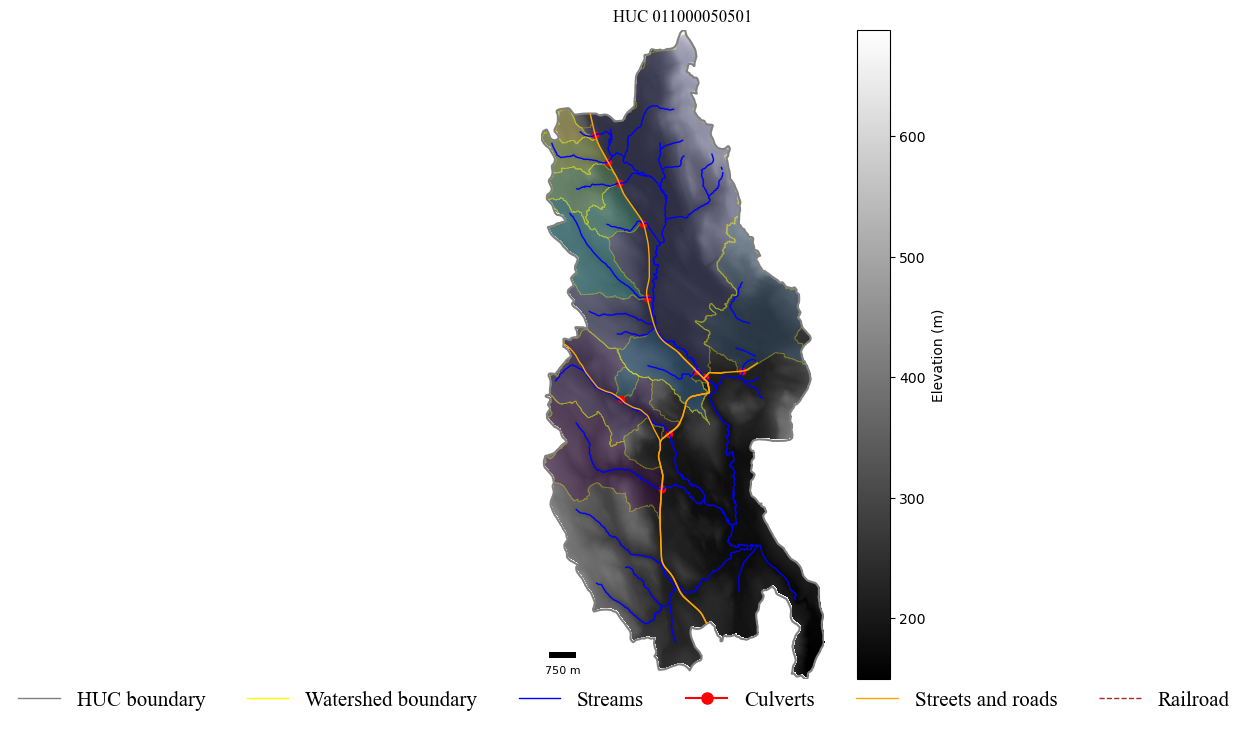

In [59]:
# Define the single HUC
huc = '011000050501'

# Define paths
output_huc12_path = os.path.join(r'D:\culvert repo\Results\Clipped_layers\clipped_huc12', f'{huc}_huc12.shp')
output_watershed_path=os.path.join(fr'D:\culvert repo\Results\waterhsed_delineation_dir\{huc}', f'{huc}_watersheds_info.shp')
output_stream_path = os.path.join(r'D:\culvert repo\Results\Clipped_layers\clipped_streams', f'{huc}_streams.shp')
output_road_path = os.path.join(r'D:\culvert repo\Results\Clipped_layers\clipped_street', f'{huc}_streets.shp')
output_culvert_path = os.path.join(r'D:\culvert repo\Results\Clipped_layers\clipped_culverts', f'{huc}_culverts.shp')
clipped_tiff = os.path.join(rf'D:\culvert repo\Results\Clipped_layers\HUC12_one meter_DEM\{huc}', f'{huc}_DEM.tiff')
output_railroad_path = os.path.join(r'D:\culvert repo\Results\Clipped_layers\clipped_railroad', f'{huc}_railroads.shp')

# Create figure
fig, ax = plt.subplots(figsize=(7, 7))

# Define legend elements
legend_elements = [
    plt.Line2D([0], [0], color='gray', lw=1, label='HUC boundary'),
    plt.Line2D([0], [0], color='yellow', lw=1, label='Watershed boundary'),
    plt.Line2D([0], [0], color='blue', lw=1, label='Streams'),
    plt.Line2D([0], [0], marker='o', color='red', markersize=10, label='Culverts'),
    plt.Line2D([0], [0], color='orange', lw=1, label='Streets and roads'),
    plt.Line2D([0], [0], color='brown', lw=1, linestyle='dashed', label='Railroad')
]

# Read and plot DEM
if os.path.exists(clipped_tiff):
    with rasterio.open(clipped_tiff) as dem:
        dem_data = dem.read(1).astype(float)
        dem_data[dem_data == -99999] = np.nan
        dem_bounds = dem.bounds
        # Plot DEM
        im = ax.imshow(dem_data, cmap='gray', extent=(dem_bounds.left, dem_bounds.right, dem_bounds.bottom, dem_bounds.top))
        
        # Add colorbar
        cbar = fig.colorbar(im, ax=ax, orientation='vertical')
        cbar.set_label('Elevation (m)')

# Overlay shapefiles
# HUC12
if os.path.exists(output_huc12_path):
    gpd.read_file(output_huc12_path).boundary.plot(ax=ax, edgecolor='gray', linewidth=1.5) 
    
# Load and plot watersheds with unique colors
if os.path.exists(output_watershed_path):
    watersheds = gpd.read_file(output_watershed_path)
    # Assign unique colors
    cmap = colormaps.get_cmap('viridis')  # Get the colormap
    colors = [cmap(val) for val in np.linspace(0, 1, len(watersheds))]  # Normalize color values

    # Plot each watershed with a unique color
    for i, watershed in watersheds.iterrows():
        gpd.GeoSeries([watershed.geometry]).plot(ax=ax, color=colors[i], edgecolor='yellow', linewidth=0.5, alpha=0.3)
# Stream
if os.path.exists(output_stream_path):
    gpd.read_file(output_stream_path).plot(ax=ax, color='blue', linewidth=1)  
# Culverts
if os.path.exists(output_culvert_path):
    gpd.read_file(output_culvert_path).plot(ax=ax, color='red', markersize=20)
# Roads
if os.path.exists(output_road_path):
    gpd.read_file(output_road_path).plot(ax=ax, color='orange', linewidth=1)
# Railroads
if os.path.exists(output_railroad_path):
    gpd.read_file(output_railroad_path).plot(ax=ax, color='brown', linewidth=1.5, linestyle='dashed')

# Add scale bar
scalebar = ScaleBar(1, units='m', dimension='si-length', location='lower left',
                    length_fraction=0.1, font_properties={'size': 8}, frameon=False)
ax.add_artist(scalebar)

# Add title
ax.set_title(f'HUC {huc}', fontsize=12, fontname='Times New Roman')

# Hide axis
ax.set_axis_off()

# Add legend
fig.legend(
    handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=6, prop={'family': 'Times New Roman', 'size': 15},
    markerscale=0.8, frameon=False
)

plt.tight_layout()
plt.savefig(rf'D:\culvert repo\Results\Figures\DEM_All_layers_watersheds_{huc}.png', dpi=300, bbox_inches="tight")
plt.show()

In [45]:
# Date and time
now = datetime.datetime.now()
print(f"Date and time: {now}")

Date and time: 2025-01-31 16:17:35.630094


In [47]:
%load_ext watermark
# Print the Python version and some dependencies
%watermark -v -m -p whitebox,numpy,pandas,geopandas,matplotlib,os,subprocess,rasterio,pyproj,sys

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.20.0

whitebox  : 2.3.5
numpy     : 2.0.2
pandas    : 2.2.2
geopandas : 1.0.1
matplotlib: 3.8.4
os        : unknown
subprocess: unknown
rasterio  : 1.3.10
pyproj    : 3.6.1
sys       : 3.12.4 | packaged by conda-forge | (main, Jun 17 2024, 10:04:44) [MSC v.1940 64 bit (AMD64)]

Compiler    : MSC v.1940 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU cores   : 24
Architecture: 64bit

